<br>
<h1> Performance Metrics </h1>
<hr>
<h3> Portfolio Risk and Return Metrics </h3>
<br>
Assume that we have the benchmark, for simplicity assume a proxy for the S&P 500 Index, SPY ETF. We would like to calculate a few performance metrics:
<br>
<ol>
  <li>Rolling Annualized Return</li>
    <li>Rolling Excess Return</li>
  <li>Rolling Annualized Tracking Error</li>
   <li>Batting Average</li>
      <li>Max Drawdown</li>
      <li>Upside Capture</li>
  <li>Downside Capture</li>
  <li>Annualized Return</li>
  <li>Annualized Volatility</li>
  <li>Annualized Sharpe</li>
  <li>Annualized Tracking Error</li>
  <li>Annualized Information Ratio</li>
  <li>Beta</li>


</ol>
<br>
Consider our "portfolio" to be the Vanguard Communication Services Index Fund ETF (VOX).
<br>

In [1]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import warnings
import waterfall_chart as waterfall

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10, 5]

Consider the U.S. Treasury Securities at 1-Yr Constant Maturity as the risk-free rate.

In [2]:
# Data interval (monthly)
interval = '1mo'
# Date of calculation
end = dt.datetime.today()
# start of calculation period (relative to end - "today:)
start = end - relativedelta(years=15)
# U.S. Treasury Securities at 1-Yr Constant Maturity
Rates = 'DGS1' #FRED
# Download data using pandas DataReader ('fred' for FRED data)
Rates = web.DataReader(Rates, 'fred', start, end)
Rates = Rates.dropna()
# .values[-1] will return the last value for the set
Rates = Rates['DGS1'].values[-1]/100 # as %
r = Rates
print(f'Rates: {round(r*100,4)}%')

Rates: 4.65%


Data:

[*********************100%***********************]  2 of 2 completed


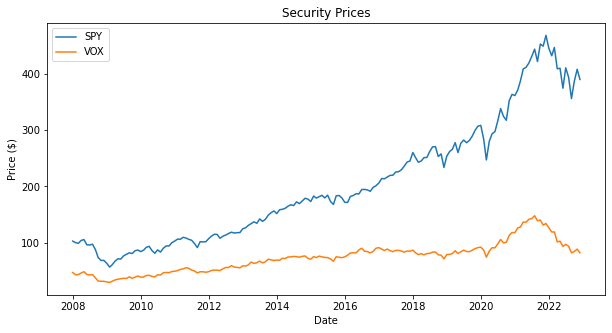

In [3]:
# Tickers from Yahoo! Finance
Tickers = ['SPY', 'VOX']
# Download data from Yahoo! (Adj Close to account for dividends and other corporate actions)
df = yf.download(Tickers, interval=interval, start=start)['Adj Close']
# Data into pandas dataframe
df = pd.DataFrame(df)
# Drop NaN (for non trading days)
df = df.dropna()

# Plots:
plt.plot(df.index, df['SPY'], df.index, df['VOX'])
plt.legend(['SPY', 'VOX'])
plt.title('Security Prices')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.show()

For returns, let's consider simple returns rather than log returns:

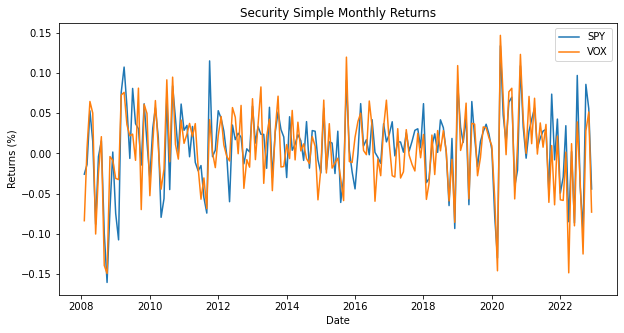

In [4]:
# Create a new DataFrame to calculate returns in continuous time
df1 = (df/df.shift(1)) - 1
# Drop first row (NaN)
df1 = df1[1::]
# Plot:
plt.plot(df1.index, df1['SPY'], df1.index, df1['VOX'])
plt.legend(['SPY', 'VOX'])
plt.title('Security Simple Monthly Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.show()

***1. Rolling Annualized Returns***
- Consider a 12-month rolling window.

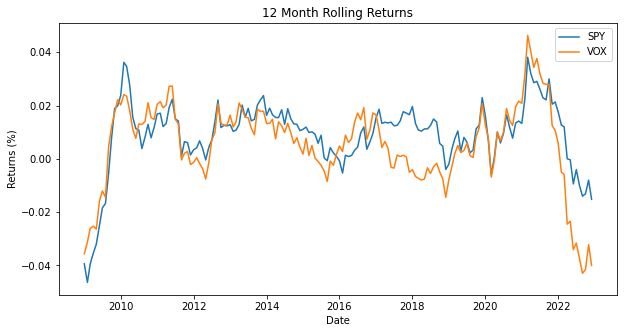

In [5]:
df1['Rolling Returns_VOX'] = (1+df1['VOX']).rolling(window=12).apply(np.prod, raw=True)**(1/12) -1
df1['Rolling Returns_SPY'] = (1+df1['SPY']).rolling(window=12).apply(np.prod, raw=True)**(1/12) -1
# Plot
plt.plot(df1.index, df1['Rolling Returns_SPY'], df1.index, df1['Rolling Returns_VOX'] )
plt.legend(['SPY', 'VOX'])
plt.title('12 Month Rolling Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.show()

***2. Rolling Annualized Excess Returns***
- Consider a 12-month rolling window.

Also consider using geometric excess returns:
<br>
\begin{align}
Excess &= \frac{1 + Portfolio_{returns}}{1 + Benchmark_{returns}} - 1
\end{align}

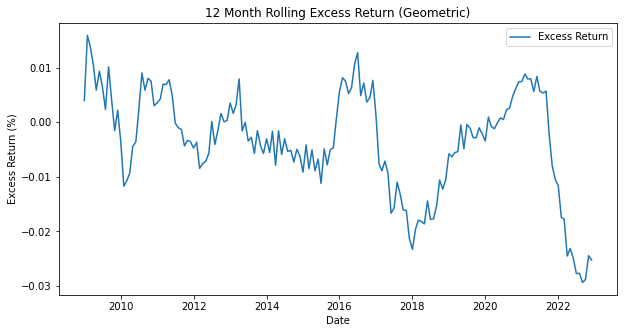

In [6]:
df1['Rolling Excess'] = ((1+df1['VOX'])/(1+df1['SPY'])).rolling(window=12).apply(np.prod, raw=True)**(1/12) -1
# Plot:
plt.plot(df1.index, df1['Rolling Excess'])
plt.legend(['Excess Return'])
plt.title('12 Month Rolling Excess Return (Geometric)')
plt.ylabel('Excess Return (%)')
plt.xlabel('Date')
plt.show()

***3. Rolling Annualized Tracking Error***
- Consider a 12-month rolling window.

We will continue to use the geometric excess return. Tracking error is defined as the standard deviation of excess returns:
<br>
<br>
\begin{align}
Tracking Error &= \sigma(Excess Returns) \sqrt{t}
\end{align}

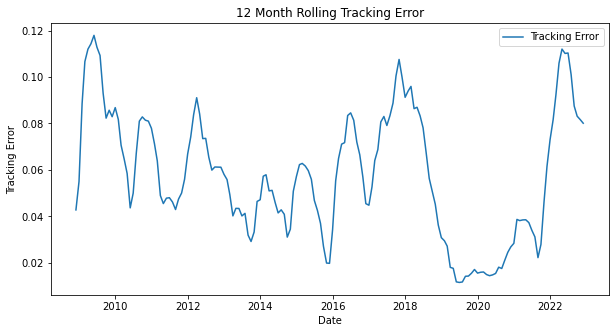

In [7]:
df1['Rolling TE'] = (((1+df['VOX'])/(1+df['SPY']))-1).rolling(window=12).std()*np.sqrt(12)
# Plot:
plt.plot(df1.index, df1['Rolling TE'])
plt.legend(['Tracking Error'])
plt.title('12 Month Rolling Tracking Error')
plt.ylabel('Tracking Error')
plt.xlabel('Date')
plt.show()

***4. Batting Average***
- For simplicity, consider the already calculated rolling returns (12 months)
- The batting average is the percentage of time that the portfolio has outperformed the benchmark (SPY), in this case on a rolling basis

In [8]:
Batting_Average = sum(df1['Rolling Returns_VOX'] > df1['Rolling Returns_SPY'])/df1['Rolling Returns_VOX'].count()
print(f"Batting Average: {round(Batting_Average*100,3)}%")

Batting Average: 36.905%


***5. Max Drawdown***
- Maximum Drawdown measures the largest price drop from a peak. To calculate the maximum drawdown of each asset, let's first calculate the drawdown.

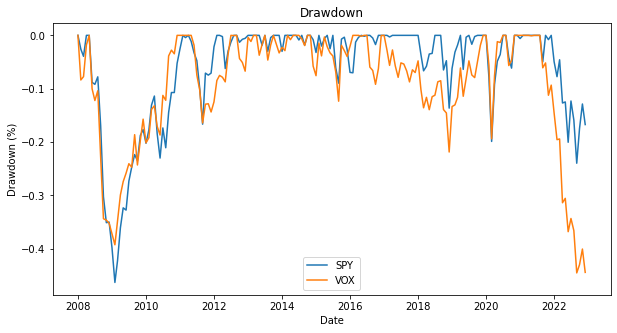

SPY Max Drawdown: -46.322%
VOX Max Drawdown: -44.533%


In [9]:
# Create a rolling maximum windown
Roll_Max_SPY = df['SPY'].cummax()
Roll_Max_VOX = df['VOX'].cummax()
# The monthly drawdown
M_Drawdown_SPY = (df['SPY']/Roll_Max_SPY) - 1
M_Drawdown_VOX = (df['VOX']/Roll_Max_VOX) - 1

# Plot:
plt.plot(df.index, M_Drawdown_SPY, df.index, M_Drawdown_VOX )
plt.legend(['SPY', 'VOX'])
plt.title('Drawdown')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.show()

# Max Drawdown:
# this is the minimum value of the drawdown:
SPY_MDD = M_Drawdown_SPY.min()
VOX_MDD = M_Drawdown_VOX.min()
print(f"SPY Max Drawdown: {round(SPY_MDD*100,3)}%")
print(f"VOX Max Drawdown: {round(VOX_MDD*100,3)}%")

***6. Upside Capture***
- Upside capture ratios for funds are calculated by taking the fund's monthly return during months when the benchmark had a positive return and dividing it by the benchmark return during that same month <a href=" https://www.morningstar.com/invglossary/upside-downside-capture-ratio.aspx#:~:text=Upside%20capture%20ratios%20for%20funds,return%20during%20that%20same%20month">(Morningstar® glossary of investing definitions)</a>

In [10]:
Up_BM = (np.product(1+df1[df1['SPY']>0]['SPY'])**(12/((df1[df1['SPY']>0]['SPY'].count()))))-1
Up_Port = (np.product(1+df1[df1['SPY']>0]['VOX'])**(12/((df1[df1['SPY']>0]['SPY'].count()))))-1
# Upside Capture:
UC = Up_Port/Up_BM
print(f"Upside Capture: {round(UC*100,3)}%")

Upside Capture: 71.53%


***7. Downside Capture***

In [11]:
Down_BM = (np.product(1+df1[df1['SPY']<=0]['SPY'])**(12/((df1[df1['SPY']<=0]['SPY'].count()))))-1
Down_Port = (np.product(1+df1[df1['SPY']<=0]['VOX'])**(12/((df1[df1['SPY']<=0]['SPY'].count()))))-1
# Upside Capture:
DC = Down_Port/Down_BM
print(f"Upside Capture: {round(DC*100,3)}%")

Upside Capture: 93.968%


***8 - 13. Annualized Return, Annualized Volatility, Annualized Sharpe, Annualized Tracking Error, Annualized Information Ratio, & Beta***

In [12]:
# Annualized Return:
SPY_AR = ((np.prod(1+df1['SPY']))**(12/((df1['SPY'].count()))))-1
VOX_AR = ((np.prod(1+df1['VOX']))**(12/((df1['VOX'].count()))))-1
# Annualized Volatility:
SPY_SD = df1['SPY'].std()*np.sqrt(12)
VOX_SD = df1['VOX'].std()*np.sqrt(12)
# Annualized Sharpe:
SPY_S = (SPY_AR - r)/SPY_SD
VOX_S = (VOX_AR - r)/VOX_SD
# Annualized Tracking Error:
VOX_TE = (((1+df['VOX'])/(1+df['SPY']))-1).std()*np.sqrt(12)
# Annualized Information Ratio:
VOX_IR = (VOX_AR - SPY_AR)/VOX_TE
# Beta:
VOX_BETA = np.polyfit(df1['SPY'],df1['VOX'],1)[0]

In [13]:
AR = [round(SPY_AR,3), round(VOX_AR,3)]
SD = [round(SPY_SD,3), round(VOX_SD,3)]
SHARPE = [round(SPY_S,3), round(VOX_S,3)]
TE = ['-', round(VOX_TE,3)]
IR = ['-', round(VOX_IR,3)]
BETA = ['-', round(VOX_BETA,3)]
Metrics = [AR, SD, SHARPE, TE, IR, BETA]
Metrics = pd.DataFrame(Metrics)
Metrics.columns = ['SPY - Benchamrk', 'VOX']
Metrics.insert(0,'Metrics',['Annualized Return', 'Annualized Volatility', 'Sharpe', 
                            'Tracking Error', 'Information Ratio', 'Beta'])
Metrics

,Metrics,SPY - Benchamrk,VOX
0,Annualized Return,0.093,0.038
1,Annualized Volatility,0.165,0.175
2,Sharpe,0.285,-0.048
3,Tracking Error,-,0.283
4,Information Ratio,-,-0.196
5,Beta,-,0.863


________________________________________________________________________________________________________________________
###### Leonardo F. de Souza
###### 2022